In [9]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata

In [10]:
sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.5.post3 anndata==0.7.1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1


In [11]:
from process_raw_data import *

### Set up processing parameters

In [12]:
cellBCpath = '/wynton/scratch/bp205/barcodes/AA_barcode_identities.csv'
geneBCpath = '/wynton/scratch/bp205/barcodes/sample_barcodes/HCC_AA_multiseq_barcodes.txt'
matrixPath = '/wynton/scratch/bp205/raw/HCC_AA/filtered_gene_bc_matrices/GRCh38/'

outfilePathFiltNorm = '/wynton/scratch/bp205/processed/HCC_AA_filtered_normalized_adata.h5ad'
outfilePathFiltNorm_loom = '/wynton/scratch/bp205/processed/HCC_AA_filtered_normalized_adata.loom'
outfilePathFiltNorm_R = '/wynton/scratch/bp205/processed/HCC_AA_filtered_normalized_adata_R/'
outfilePathFiltNorm_csv = '/wynton/scratch/bp205/processed/HCC_AA_filtered_normalized_adata_R/HCC_AA_filtered_normalized_adata.csv'

outfilePathFilt = '/wynton/scratch/bp205/processed/HCC_AA_filtered_adata.h5ad'
outfilePathFilt_loom = '/wynton/scratch/bp205/processed/HCC_AA_filtered_adata.loom'
outfilePathFilt_R = '/wynton/scratch/bp205/processed/HCC_AA_filtered_adata_R/'
outfilePathFilt_csv = '/wynton/scratch/bp205/processed/HCC_AA_normalized_adata_R/HCC_AA_filtered_adata.csv'

outfilePathNorm = '/wynton/scratch/bp205/processed/HCC_AA_normalized_adata.h5ad'
outfilePathNorm_loom = '/wynton/scratch/bp205/processed/HCC_AA_normalized_adata.loom'
outfilePathNorm_R = '/wynton/scratch/bp205/processed/HCC_AA_normalized_adata_R/'
outfilePathNorm_csv = '/wynton/scratch/bp205/processed/HCC_AA_normalized_adata_R/HCC_AA_normalized_adata.csv'

outfilePath = '/wynton/scratch/bp205/processed/HCC_AA_adata.h5ad'
outfilePath_loom = '/wynton/scratch/bp205/processed/HCC_AA_adata.loom'
outfilePath_R = '/wynton/scratch/bp205/processed/HCC_AA_adata_R/'
outfilePath_csv = '/wynton/scratch/bp205/processed/HCC_AA_adata_R/HCC_AA_adata.csv'


minN_genes = 200
minN_cells = 3
maxN_genes = 5000
maxMito_percent = 0.09

### Load Cell barcodes and Sample barcodes

In [13]:
cellBC = pd.read_csv(cellBCpath, usecols=[1,2,3])
cellBC = cellBC[cellBC['multiseq barcode']!='DOUBLET']

geneBC = pd.read_csv(geneBCpath, sep='\t', index_col=0)
BCmap = create_barcode_map(cellBC, geneBC)

KeyError: nan

In [ ]:
BCmap.head()

### Loading raw sample x gene counts matrix

In [ ]:
adata = read_matrix(matrixPath)

In [ ]:
adata = add_cell_type_to_obs(adata, BCmap)

### Visalizing the highest expression genes 

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Remove cells with fewer gene counts than a detection threshold, and are found in fewer than $n$ cells

In [ ]:
adata = filter_minGenes_minCells(adata, minN_genes, minN_cells)

Remove all cells which are not mapped to a specific sample (due to degenerate MULTI or genetic barcodes)

In [ ]:
adata = keep_real_cells(adata)

### Determining % mitochondria-associated genes 

In [ ]:
adata = calc_percentMito_nCounts(adata)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [ ]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

### Filtering out cells with high gene counts, and high mitochondrial percentage

In [8]:
adata = filter_genes_mito(adata, maxN_genes, maxMito_percent)

NameError: name 'adata' is not defined

In [125]:
adata.shape

(3556, 16759)

### Normalize count matrix (Total Normalization) and log-transform the count values

In [126]:
adata, backup = normalize_and_log(adata)

normalizing counts per cell
    finished (0:00:04)


/wynton/home/students/snanda/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [127]:
## Save an unnormalized, unprocessed version of the file
backup.write(outfilePath)
backup.write_loom(outfilePath_loom)
backup.write_csvs(outfilePath_R)
np.savetxt(outfilePath_csv,backup.X.todense(),delimiter=',')

writing .csv files to /wynton/scratch/bp205/processed/HCC_AA_adata_R


In [128]:
## Save a processed version of the file
adata.write(outfilePathNorm)
adata.write_loom(outfilePathNorm_loom)
adata.write_csvs(outfilePathNorm_R)
np.savetxt(outfilePathNorm_csv,adata.X.todense(),delimiter=',')

writing .csv files to /wynton/scratch/bp205/processed/HCC_AA_normalized_adata_R


### Plot highly variable genes 

extracting highly variable genes


/wynton/home/students/snanda/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:58: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


    finished (0:00:01)


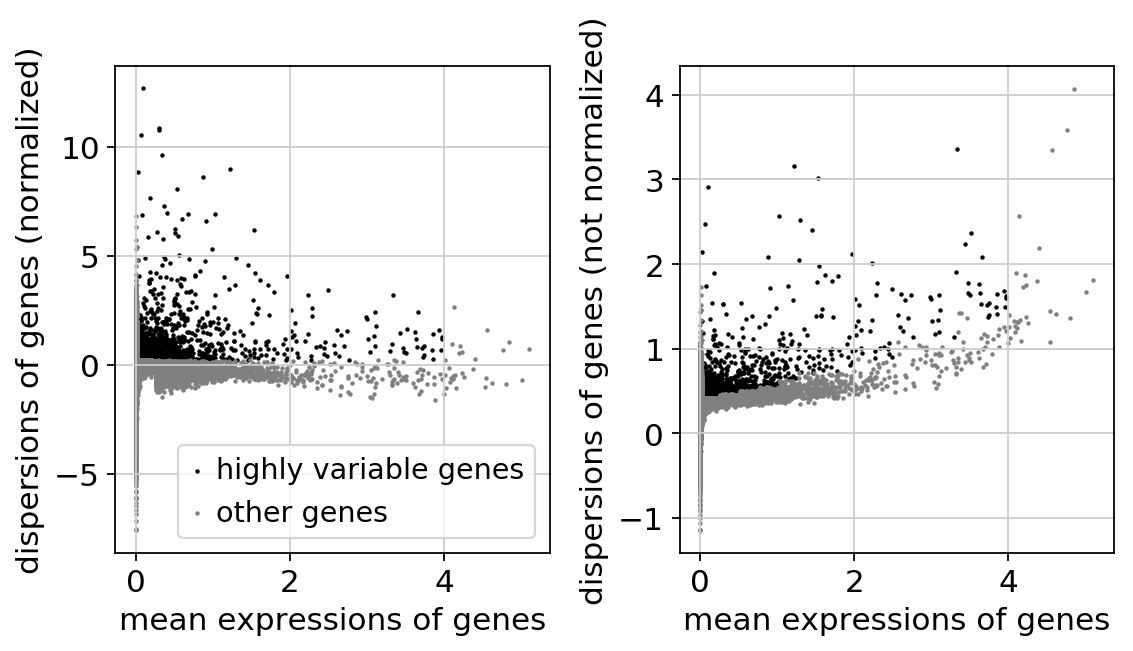

In [129]:
sc.pp.highly_variable_genes(adata, min_mean=0.02, max_mean=4, min_disp=0.2)
sc.pl.highly_variable_genes(adata)

### Keep only genes which are 'highly variable'

In [130]:
backup_filtered = backup.copy()[:,adata.var.highly_variable]
backup_filtered.write(outfilePathFilt)
backup_filtered.write_loom(outfilePathFilt_loom)
backup_filtered.write_csvs(outfilePathFilt_R)
np.savetxt(outfilePathFilt_csv,backup_filtered.X.todense(),delimiter=',')

writing .csv files to /wynton/scratch/bp205/processed/HCC_AA_filtered_adata_R


In [131]:
adata = adata[:, adata.var.highly_variable]

### Regress out the mitochondrial fraction and total counts, rescale the data, and perform PCA

In [132]:
adata = regress_scale_pca(adata)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:19)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:03)


In [133]:
## Save a processed version of the file
adata.write(outfilePathFiltNorm)
adata.write_loom(outfilePathFiltNorm_loom)
adata.write_csvs(outfilePathFiltNorm_R)
np.savetxt(outfilePathFiltNorm_csv,adata.X,delimiter=',')

The loom file will lack these fields:
{'X_pca', 'PCs'}
Use write_obsm_varm=True to export multi-dimensional annotations
writing .csv files to /wynton/scratch/bp205/processed/HCC_AA_filtered_normalized_adata_R
